# Correct viral barcodes to reduce replication, PCR, and sequencing errors
This Python Jupyter notebook uses `UMI_tools` directional adjacency method to correct viral barcodes that are likely derived from errors in the replication or sequencing library preparation process.

## Notes about UMI_tools
* Using directional adjacency method. This has been demonstrated on simulated data to produce a more accurate result than other heuristics.
* Sequence must be input as byte. See definition here: https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal
* The corrected barcode is returned as the first barcode in the group list. See umi_tools API documentation: https://umi-tools.readthedocs.io/en/latest/API.html

Import Python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import gzip

import numpy as np

import pandas as pd

import plotnine as p9

from umi_tools import UMIClusterer

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial2_viral_bc_in_progeny_freq.csv.gz'

Import barcode frequency data

In [3]:
viral_bc_df = pd.read_csv(gzip.open(viral_bc_in_progeny_freq_csv))
display(viral_bc_df)

,source,tag,gene,barcode,mean_freq
0,second_infection,syn,fluHA,AAAAAAAGTAAATCTT,4.967883e-05
1,second_infection,syn,fluHA,AAAAAAATCTTAATAA,1.780615e-06
2,second_infection,syn,fluHA,AAAAAAATCTTAATGA,8.840638e-05
3,second_infection,syn,fluHA,AAAAAACAATGACTAA,9.349045e-07
4,second_infection,syn,fluHA,AAAAAACCCAATTATT,9.349045e-07
...,...,...,...,...,...
149148,supernatant,wt,fluNA,TTTTGTTAGCGTCCTG,3.000532e-04
149149,supernatant,wt,fluNA,TTTTTTAGAAAACGTA,7.892971e-07
149150,supernatant,wt,fluNA,TTTTTTAGAAAACGTC,1.610166e-04
149151,supernatant,wt,fluNA,TTTTTTCACTGCCATT,7.892971e-07


Cluster barcodes within each sample

In [4]:
clusterer = UMIClusterer(cluster_method="directional")

lookup_list = []

for (source, tag, gene), df in (viral_bc_df
                                .groupby(['source',
                                          'tag',
                                          'gene'])):
    n_unique_bc = df['barcode'].nunique()
    print(f"There are {n_unique_bc} unique barcodes in the raw data for {source} {tag} {gene}")
    
    # Convert dataframe to dictionary. Dict is requried input type for umi_tools clustering.
    viral_bc_dict = (df[['barcode','mean_freq']]
                     .set_index('barcode')
                     .to_dict(orient='dict'))
    viral_bc_dict = viral_bc_dict['mean_freq']
    
    # Convert barcode strings to byte. Byte is required dtype for umi_tools clustering.
    byte_dict={}
    for key, value in viral_bc_dict.items(): 
        byte_dict[key.encode("utf-8")] = float(value)
    
    # Cluster barcodes
    bc_groups = clusterer(byte_dict, threshold=1)
    groups_df = pd.DataFrame(bc_groups)
    groups_df = groups_df.stack().str.decode('utf-8').unstack() # Convert bytes back to string
    groups_df = groups_df.rename(columns={0:'corrected_bc'})
    groups_df = groups_df.set_index('corrected_bc', drop=False)
    n_corrected_bc = groups_df['corrected_bc'].nunique()
    print(f"{n_unique_bc - n_corrected_bc} barcodes were corrected.")
    print(f"There are {n_corrected_bc} corrected barcodes for {source} {tag} {gene}\n")
    
    # Generate lookup table for this sample
    temp_lookup_df = (groups_df.melt(ignore_index=False,
                                value_name='original_bc')
                      ['original_bc']
                      .dropna()
                      .reset_index())
    temp_lookup_df['source'] = source
    temp_lookup_df['tag'] = tag
    temp_lookup_df['gene'] = gene
    lookup_list.append(temp_lookup_df)

lookup_df = pd.concat(lookup_list)
display(lookup_df.describe())

There are 23862 unique barcodes in the raw data for second_infection syn fluHA
7528 barcodes were corrected.
There are 16334 corrected barcodes for second_infection syn fluHA

There are 24756 unique barcodes in the raw data for second_infection syn fluNA
5126 barcodes were corrected.
There are 19630 corrected barcodes for second_infection syn fluNA

There are 28801 unique barcodes in the raw data for second_infection wt fluHA
8573 barcodes were corrected.
There are 20228 corrected barcodes for second_infection wt fluHA

There are 22847 unique barcodes in the raw data for second_infection wt fluNA
5697 barcodes were corrected.
There are 17150 corrected barcodes for second_infection wt fluNA

There are 13478 unique barcodes in the raw data for supernatant syn fluHA
5598 barcodes were corrected.
There are 7880 corrected barcodes for supernatant syn fluHA

There are 11179 unique barcodes in the raw data for supernatant syn fluNA
5555 barcodes were corrected.
There are 5624 corrected barcod

,corrected_bc,original_bc,source,tag,gene
count,149153,149153,149153,149153,149153
unique,72033,119543,2,2,2
top,TGTTATATTTGTATTG,TCCCTAGACACAAAAG,second_infection,wt,fluHA
freq,135,6,100266,75878,81220


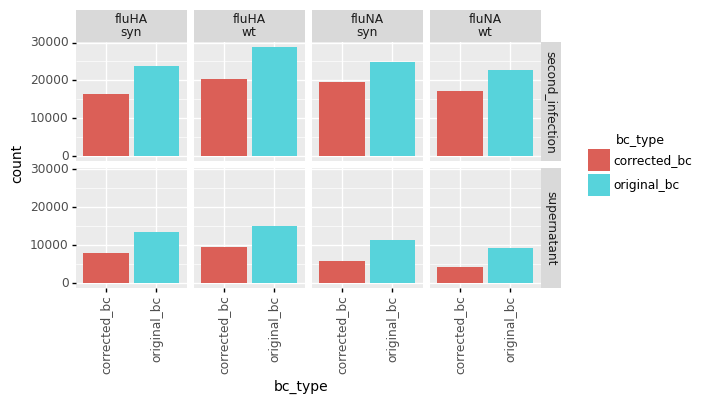

In [5]:
temp_df = (lookup_df
           .groupby(['source','tag','gene'])
           .nunique()
           .reset_index()
           .melt(id_vars=['source','tag','gene'])
           .rename(columns={'variable':'bc_type',
                              'value':'count'}))

fig = (p9.ggplot(temp_df, p9.aes(x='bc_type', y='count', fill='bc_type')) +
       p9.geom_bar(stat='identity',position='dodge') +
       p9.facet_grid('source~gene+tag') +
       p9.scale_x_discrete(limits=(temp_df['bc_type']
                                   .unique()
                                   .tolist())) +  # Order categorical values
       p9.theme(figure_size=(1.5*((temp_df['gene'].nunique() *
                                   temp_df['tag'].nunique())),
                             1.6*temp_df['source'].nunique()),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))

fig.draw()

Merge corrected barcode data with barcode frequency data. Aggregate frequency on corrected barcodes.

In [6]:
viral_bc_df = pd.merge(viral_bc_df,
                       lookup_df,
                       left_on = ['source','tag','gene','barcode'],
                       right_on=['source','tag','gene','original_bc'])
viral_bc_df = viral_bc_df.drop('barcode', axis=1)

In [7]:
viral_bc_df = pd.merge(viral_bc_df,
                       viral_bc_df.groupby(['source','tag','gene','corrected_bc']).sum().reset_index(),
                       on=['source','tag','gene','corrected_bc'],
                       suffixes=['_original_bc','_corrected_bc'])

In [8]:
viral_bc_df['diff'] = viral_bc_df['mean_freq_corrected_bc'] - viral_bc_df['mean_freq_original_bc'] 
viral_bc_df['diff_ratio'] = viral_bc_df['diff'] / viral_bc_df['mean_freq_original_bc']
viral_bc_df

,source,tag,gene,mean_freq_original_bc,corrected_bc,original_bc,mean_freq_corrected_bc,diff,diff_ratio
0,second_infection,syn,fluHA,4.967883e-05,AAAAAAAGTAAATCTT,AAAAAAAGTAAATCTT,0.000050,0.000000e+00,0.000000
1,second_infection,syn,fluHA,1.780615e-06,AAAAAAATCTTAATGA,AAAAAAATCTTAATAA,0.000090,8.840638e-05,49.649358
2,second_infection,syn,fluHA,8.840638e-05,AAAAAAATCTTAATGA,AAAAAAATCTTAATGA,0.000090,1.780615e-06,0.020141
3,second_infection,syn,fluHA,9.349045e-07,AAAGAACAATGACTAA,AAAAAACAATGACTAA,0.000062,6.120822e-05,65.470031
4,second_infection,syn,fluHA,6.120822e-05,AAAGAACAATGACTAA,AAAGAACAATGACTAA,0.000062,9.349045e-07,0.015274
...,...,...,...,...,...,...,...,...,...
149148,supernatant,wt,fluNA,2.123209e-04,TTTTCTCACTGCCATT,TTTTCTCACTGCCATT,0.000216,3.946486e-06,0.018587
149149,supernatant,wt,fluNA,7.892971e-07,TTTTCTCACTGCCATT,TTTTTTCACTGCCATT,0.000216,2.154781e-04,273.000000
149150,supernatant,wt,fluNA,1.845688e-04,TTTTGTCATGATAGCC,TTTTGTCATGATAGCC,0.000186,1.031111e-06,0.005587
149151,supernatant,wt,fluNA,1.031111e-06,TTTTGTCATGATAGCC,TTTTGTCATGATAGCT,0.000186,1.845688e-04,179.000000


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


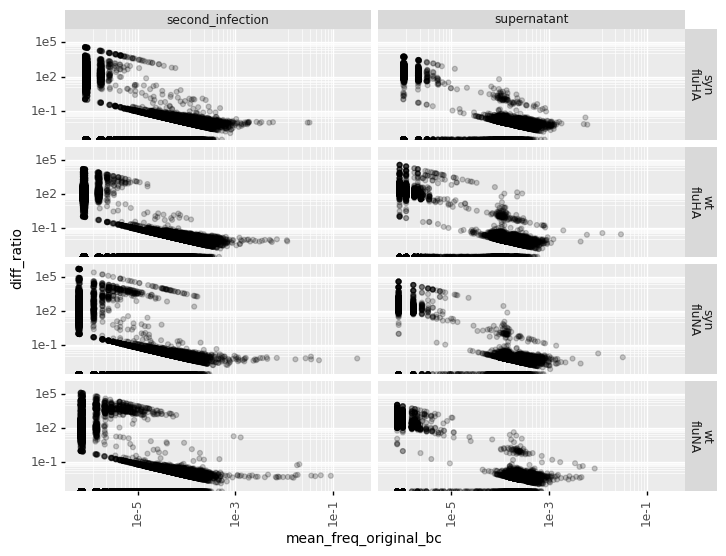

In [9]:
fig = (p9.ggplot(viral_bc_df, p9.aes(x='mean_freq_original_bc',
                                     y='diff_ratio')) +
       p9.geom_point(alpha=0.2) +
       p9.facet_grid('gene+tag~source') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(4*viral_bc_df['source'].nunique(),
                             1.5*((viral_bc_df['gene'].nunique() *
                                   viral_bc_df['tag'].nunique()))),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))

fig.draw()